In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Iterable, List
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

import collections
import pandas as pd 
import numpy as np
import random 
from torch.utils.data import DataLoader, random_split
import os
import scanpy as sc

from model import Encoder, Decoder, gene_act
from loss_function import MMD_LOSS

In [24]:
# Data
path_mtx = r"./data/mtx_0.mtx"
data_test = sc.read_mtx(path_mtx)
mtx_data = np.array(data_test.X.todense())

In [9]:
print(mtx_data.T.shape)

(27943, 238)


In [96]:
batch_size = 64
all_data = mtx_data
random.seed(214)
m = len(all_data)
print(m)

train_data, test_data = random_split(dataset=all_data, lengths=[int(m - m * 0.2), int(m * 0.2) + 1])

print((train_data.dataset.shape))
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
print(train_loader)

238
(238, 27943)


In [97]:
for i in train_loader:
    print(i.shape)
    break

torch.Size([64, 27943])


In [98]:

encoder = Encoder(features=[all_data.shape[1], 1024, 256, 64, 16])
decoder = Decoder(features=[all_data.shape[1], 1024, 256, 64, 16][::-1])


loss_fn = MMD_LOSS()

# Define Optimizer
lr = 0.001

#Random seed
torch.manual_seed(0)
param_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(param_to_optimize, lr=lr, weight_decay=1e-05)

def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

In [99]:
# ls = MMD_LOSS()
ls = nn.MSELoss()
# ls.forward()
# print(ls([1,2,3], [1,2,3]))
a = torch.zeros([2, 4])
b = torch.ones([2,4])
print(a, b)
# ls.forward(a, b)
print(ls.forward(a, b))

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]]) tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor(1.)


In [100]:
# Training
def train_epoch(encoder, decoder, dataloader, loss_fn, optimizer, noise_factor=0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    for sc_data_batch in dataloader:
        # _
        sc_data_noisy = add_noise(sc_data_batch, noise_factor)
        # Encode
        encoded_data = encoder(sc_data_noisy)
        # Decode
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, sc_data_noisy)
        # Backword 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print
        # print('\t partial train loss : %f' %(loss.data))
        train_loss.append(loss.detach().numpy())
    return np.mean(train_loss)

In [101]:
# Testing func
def test_epoch(encoder, decoder, dataloader, loss_fn, noise_factor=0.3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # Don't track gradients
        # conc_out = []
        # conc_label = []
        for sc_data_batch in dataloader:
            sc_data_noisy = add_noise(sc_data_batch, noise_factor)
            # Encode
            encoded_data = encoder(sc_data_noisy)
            # Decode
            decoded_data = decoder(encoded_data)
            # Append the output list to the original image
            # conc_out.append(decoded_data)
            # conc_label.append(sc_data_batch)
            # Create single tensor with all values
            # conc_out = torch.cat(conc_out)
            # conc_label = torch.cat(conc_label)
            # Evaluate global loss
            val_loss = loss_fn(decoded_data, sc_data_noisy)
    return val_loss / len(dataloader.dataset)        

In [102]:
# def plot_ae_outputs(encoder,decoder,n=5):
#     plt.figure(figsize=(10,4.5))
#     for i in range(n):
#       ax = plt.subplot(2,n,i+1)
#       img = test_dataset[i][0].unsqueeze(0)
#       encoder.eval()
#       decoder.eval()
#       with torch.no_grad():
#          rec_img  = decoder(encoder(img))
#       plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
#       ax.get_xaxis().set_visible(False)
#       ax.get_yaxis().set_visible(False)  
#       if i == n//2:
#         ax.set_title('Original images')
#       ax = plt.subplot(2, n, i + 1 + n)
#       plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
#       ax.get_xaxis().set_visible(False)
#       ax.get_yaxis().set_visible(False)  
#       if i == n//2:
#          ax.set_title('Reconstructed images')
#     plt.show()

In [103]:
num_epochs = 50
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder, train_loader,loss_fn,optim)
   test_loss = test_epoch(encoder,decoder,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,test_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(test_loss)


 EPOCH 1/50 	 train loss 1.274095058441162 	 val loss 0.2253832221031189

 EPOCH 2/50 	 train loss 1.0065284967422485 	 val loss 0.21919041872024536

 EPOCH 3/50 	 train loss 0.8679742813110352 	 val loss 0.21091298758983612

 EPOCH 4/50 	 train loss 0.8557989001274109 	 val loss 0.19935517013072968

 EPOCH 5/50 	 train loss 0.8024044036865234 	 val loss 0.1872086375951767

 EPOCH 6/50 	 train loss 0.7701113224029541 	 val loss 0.16937290132045746

 EPOCH 7/50 	 train loss 0.7704030871391296 	 val loss 0.1525258719921112

 EPOCH 8/50 	 train loss 0.777195155620575 	 val loss 0.1297452598810196

 EPOCH 9/50 	 train loss 0.7641347050666809 	 val loss 0.11660504341125488

 EPOCH 10/50 	 train loss 0.7740700840950012 	 val loss 0.11759323626756668

 EPOCH 11/50 	 train loss 0.7543278336524963 	 val loss 0.12235695123672485

 EPOCH 12/50 	 train loss 0.730754554271698 	 val loss 0.11142468452453613

 EPOCH 13/50 	 train loss 0.7407973408699036 	 val loss 0.10077989846467972

 EPOCH 14/50 	

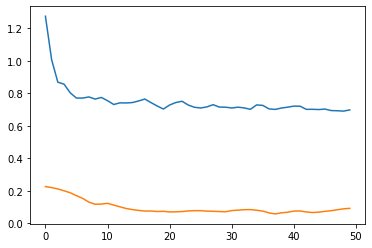

In [104]:
# PLOT
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# print(diz_loss)
x_ax = range(len(diz_loss['train_loss']))
# print(x_ax)
# y_tcs = np.arange(0.1, 1, 0.05)
# ax.set_ylim([0.1, 0.4])
# plt.yticks(y_tcs)
plt.plot(x_ax, diz_loss['train_loss'])
plt.plot(x_ax, diz_loss['val_loss'])



## MMD model from Kaggle

In [134]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y):
    '''
    Using gaussian kernel for MMD
    '''
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    print(xx, xx.diag(),xx.diag().unsqueeze(0), rx)
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    # applying kernel method
    sigmas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100, 1e3, 1e4, 1e5, 1e6]
    for sigma in sigmas:
        XX += torch.exp(-0.5*dxx/sigma)
        YY += torch.exp(-0.5*dyy/sigma)
        XY += torch.exp(-0.5*dxy/sigma)

    return torch.mean(XX + YY - 2. * XY)